In [12]:
# Data Manipulation
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import joblib

# Metrics
from sklearn.metrics import mean_squared_error

sns.set(rc={"figure.figsize": (16, 3)})

# Overview

Our goal is to build a model that gets information about a player (age, position, skills, etc.) and predicts the value of the player. To do this, we apply a baseline model. Since this projects main focus is on EDA, we'll omit further modelling here but give an outlook over what could be done.

## Data preparation

In [2]:
df = pd.read_csv(os.path.join("..", "data", "post_eda_data.csv"))
df.head()

,short_name,long_name,age,height_cm,weight_kg,nationality,club,overall,potential,value_eur,...,is_LW,is_LWB,is_RB,is_RM,is_RW,is_RWB,is_ST,is_defender,is_midfielder,is_striker
0,L. Messi,Lionel Andrés Messi Cuccittini,32,170,72,Argentina,FC Barcelona,94,94,95500000,...,0,0,0,0,1,0,1,False,False,True
1,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,187,83,Portugal,Juventus,93,93,58500000,...,1,0,0,0,0,0,1,False,False,True
2,Neymar Jr,Neymar da Silva Santos Junior,27,175,68,Brazil,Paris Saint-Germain,92,92,105500000,...,1,0,0,0,0,0,0,False,True,True
3,J. Oblak,Jan Oblak,26,188,87,Slovenia,Atlético Madrid,91,93,77500000,...,0,0,0,0,0,0,0,False,False,False
4,E. Hazard,Eden Hazard,28,175,74,Belgium,Real Madrid,91,91,90000000,...,1,0,0,0,0,0,0,False,False,True


Lets get rid of all information we dont want to provide to our model for predicting the value of a player:

In [3]:
drop_columns = [
    "short_name", "long_name", "nationality", "club", "potential", "wage_eur", "player_positions",
    "release_clause_eur", "player_tags", "team_jersey_number", "player_traits", "team_position",
     "pace", "shooting", "passing", "dribbling", "defending", "physic",
]

df = df.drop(drop_columns, axis=1)

Now we scale the target column, value_eur. Because the values are so large and contain a great range (<100.000 to >100.000.000) it would not be suitable to calculate errors i.e. via MSE. Therefore, we scale the column by applying the logarithm to it

In [4]:
df["log_value_eur"] = np.log(df.value_eur)

In [5]:
df.columns

Index(['age', 'height_cm', 'weight_kg', 'overall', 'value_eur',
       'preferred_foot', 'international_reputation', 'weak_foot',
       'skill_moves', 'contract_valid_until', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning'

In [6]:
# Reorder columns s.t. the to be predicted variable is in front
# Adds usability
cols = ["value_eur", "log_value_eur"] + list(df.columns)[:4] + list(df.columns)[5:-1]
df = df[cols]

First, lets prepare an independant test set to test our models on. For the given dataset it would make more sense to do a nested cross validation to define multiple test sets. However, we omit this and define a fixed set.

In [7]:
np.random.seed(42)
testset_rel_size = 0.1  # Use 10% of overall data as test set

test_indices = np.random.choice(df.index, size=np.int(len(df)*testset_rel_size), replace=False)
df_test = df[df.index.isin(test_indices)]
df_train = df[~df.index.isin(test_indices)]

Now we prepare folds for a cross validation. Lets do five folds as a baseline

In [8]:
kf = KFold(n_splits=5, random_state=27, shuffle=True)
cv_dataframes = {k: [] for k in ["train", "val"]}  # Dict train and val DF for each split

for i, (train_indices, val_indices) in enumerate(kf.split(df_train)):
    print(f"Split {i} set sizes:   {len(train_indices)} / {len(val_indices)}   (Train / Val)")
    
    cv_dataframes["train"].append(df_train[df_train.index.isin(train_indices)])
    cv_dataframes["val"].append(df_train[df_train.index.isin(val_indices)])

Split 0 set sizes:   12980 / 3246   (Train / Val)
Split 1 set sizes:   12981 / 3245   (Train / Val)
Split 2 set sizes:   12981 / 3245   (Train / Val)
Split 3 set sizes:   12981 / 3245   (Train / Val)
Split 4 set sizes:   12981 / 3245   (Train / Val)


## Baseline: RandomForestRegressor

In [9]:
def plot_error_bins(y_pred: np.array, y_true: np.array, split: int = None):
    """Create a bar plot of error bins
    """
    # Bin absolute prediction differences on logarithms
    abs_diffs = np.abs(np.exp(y_true) - np.exp(y_pred))
    abs_diffs_bins = pd.cut(abs_diffs, bins=np.arange(0, 5000000, 100000))
    
    if split is not None:
        plt.title(f"Split {split}")
    
    ax = sns.countplot(abs_diffs_bins)
    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", (p.get_x()+0.1, p.get_height()+50), rotation=25)

    plt.xticks(rotation=90)
    plt.show()

    print(f"Not included (Abs Diffs): \n {abs_diffs[abs_diffs > 5000000]}")   

MSE for split 0: 0.0085


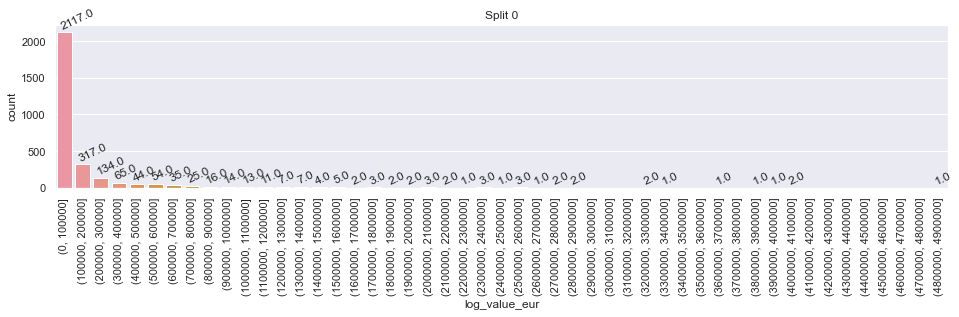

Not included (Abs Diffs): 
 12     1.697395e+07
45     8.997215e+06
96     1.817746e+07
107    6.148908e+06
109    5.791040e+06
Name: log_value_eur, dtype: float64
MSE for split 1: 0.0097


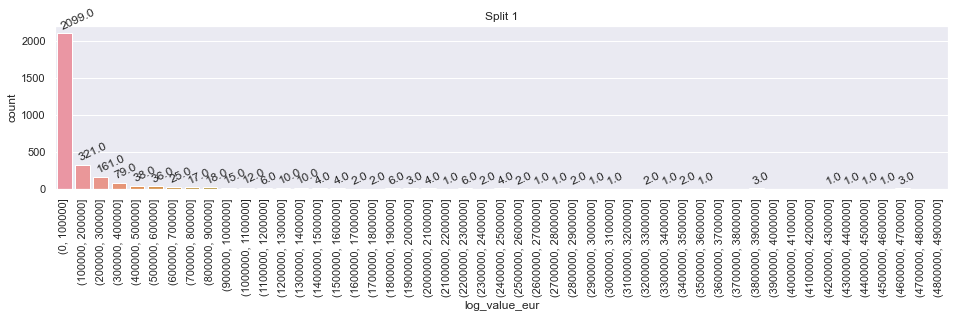

Not included (Abs Diffs): 
 0      3.528070e+07
2      3.029630e+07
6      1.647541e+07
7      2.103002e+07
8      5.586640e+06
10     2.478726e+07
27     6.444927e+06
33     1.117236e+07
42     7.372641e+06
43     5.113403e+06
44     1.469325e+07
58     5.823437e+06
92     6.767553e+06
167    6.205322e+06
294    5.236843e+06
Name: log_value_eur, dtype: float64
MSE for split 2: 0.0089


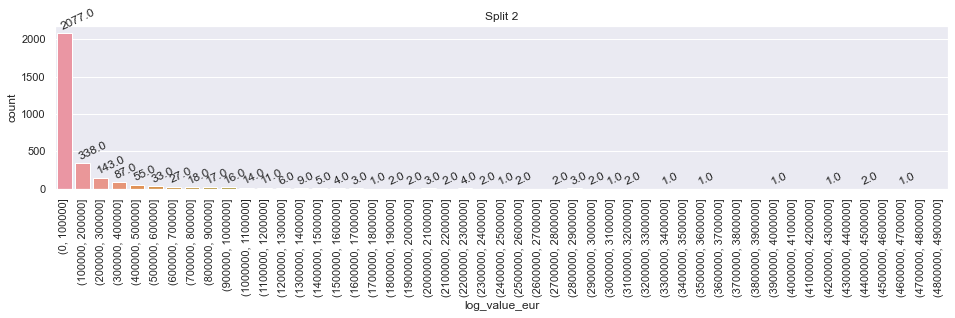

Not included (Abs Diffs): 
 4     6.457025e+06
9     7.859376e+06
22    5.307786e+06
40    5.044717e+06
55    1.296285e+07
Name: log_value_eur, dtype: float64
MSE for split 3: 0.0091


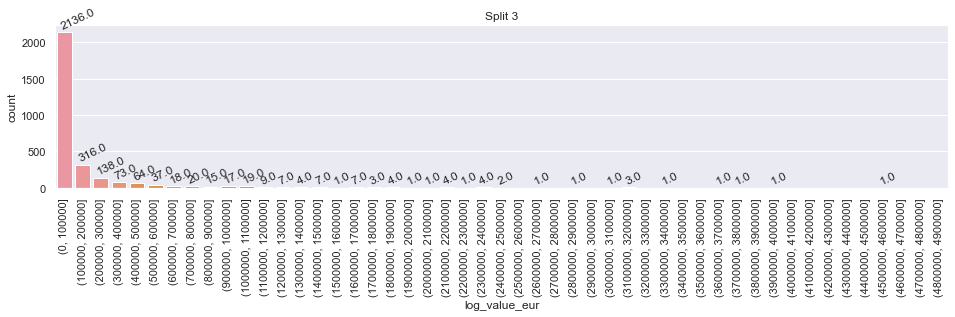

Not included (Abs Diffs): 
 5      1.888131e+07
11     1.266042e+07
24     1.231737e+07
41     1.137567e+07
128    8.094921e+06
405    8.660123e+06
Name: log_value_eur, dtype: float64
MSE for split 4: 0.0085


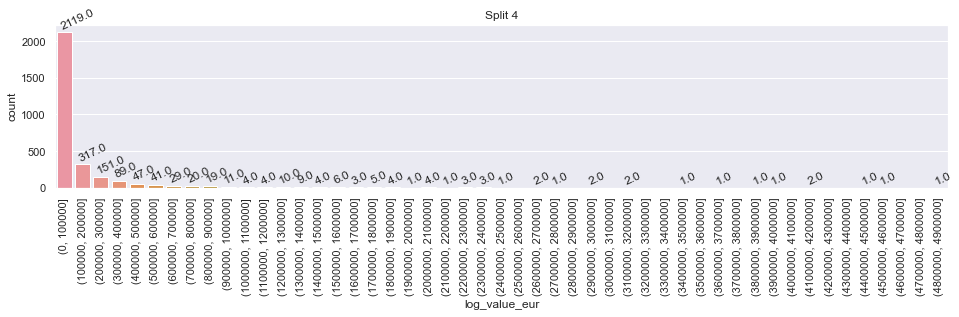

Not included (Abs Diffs): 
 16    5.274869e+06
23    1.541348e+07
26    1.248071e+07
51    5.919498e+06
52    7.025595e+06
68    6.568809e+06
Name: log_value_eur, dtype: float64

Mean MSE over all folds: 0.0089


In [10]:
list_mse = []

for i in range(kf.n_splits):
    model = RandomForestRegressor(
        n_jobs=6,
        random_state=42,
    )

    model.fit(cv_dataframes["train"][i].iloc[:, 2:], cv_dataframes["train"][i].log_value_eur)
    
    y_pred = model.predict(cv_dataframes["val"][i].iloc[:, 2:])
    y_true = cv_dataframes["val"][i].log_value_eur
    
    mse = mean_squared_error(
        y_pred,
        y_true,
    )
    
    list_mse.append(mse)
    
    print(f"MSE for split {i}: {mse:.4f}")
    plot_error_bins(y_pred, y_true, split=i)
    
print(f"\nMean MSE over all folds: {np.mean(list_mse):.4f}")

We see that even without any tuning the RandomForestRegressor performs reasonably well over all folds. The value of the majority of players is guessed up to an error margin of 100.000. However, there are single players for which the estimation error is very large. This is likely due to their high value. We've seen in the data exploration, that 75% of the players are valued at less than 2.6 million euros. This makes it hard for the algorithm to estimate the value of "superstars", because of the few ammounts of training data.

From this point on we have several possible directions we can go:

- Apply other machine learning models and compare their performance against the Random Forest
    - e.g. XGBoost, SVR, Logistic Regression, etc.


- Decide for a model and tune its parameters
    - Grid search for parameter guessing
    - Optuna for Bayesian Optimization and parameter "computation"


- Datawise:
    - Perform further feature engineering to boost performance of the models
    - Perform oversampling of "superstars" to boost model performance on high value players
    - SMOTE could be a reasonable choice to oversample and get more training data

In [13]:
joblib.dump(model, "rf_regressor.joblib")

['rf_regressor.joblib']